In [1]:
import pandas as pd
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import Graphs
import networkx as nx
import torch.optim as optim
import random
import copy
import sys
from operator import add
from torch.nn import functional as F
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
sns.set_theme(style="whitegrid")

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [3]:
def createDictFloor(floor_idx,path):
    floorname = [f'Floor{idx}' for idx in floor_idx]
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for name in floorname for floor in fulldata if name in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
        
def createDTFeat(date1, date2, datadict,featureX,resample_method_X="mean"):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        elif resample_method_X == "max":
            dataX = dataX.resample("5T").max().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["weekday"] = resample_move[floorname].index.weekday
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
        
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates

def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = copy.deepcopy(datadict)
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(scaled_data_dict[floorname][feature])
        scaled_data_dict[floorname][feature] = scaler.transform(scaled_data_dict[floorname][feature])
        scalers[floorname] = scaler
        
    return scaled_data_dict, scalers

def get_info_timeshape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [4]:
def get_info_zone(datadict):
    for data in datadict.keys():
        zone = datadict[data]
        print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
        print("")

In [5]:
seed_everything(seed=20)
date1 = "2019-03-07"
date2 = "2019-09-29"
cutting_date = "2019-04-20"
floors = [4,5,6,7]
floor_dict = createDictFloor(floors, bkdatafolder)
feature = ["temperature"]
resample_method = "mean"
resample,remain_date = createDTFeat(date1, date2, floor_dict, feature,resample_method_X=resample_method)
scaled_data, scalers = data_scaling(resample, feature)

In [6]:
def distribution(datadict, feature):
    zone_list = sorted(list(datadict.keys()))
    concat_feature = pd.DataFrame()
    for zone in zone_list:
        concat_feature = pd.concat([concat_feature, datadict[zone][feature].rename(f"{zone}")],axis=1)
    return concat_feature

In [7]:
def delete_zone(datadict,zone_to_delete):
    for zone in zone_to_delete:
        if zone in datadict.keys():
            del datadict[zone]
    return datadict

In [8]:
def plot_data(datadict, cutting_date, feature):
    zone_list = sorted(list(datadict.keys()))
    for zone in zone_list:
        plt.figure(figsize=(20,3))
        plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date][feature],label=zone)
        plt.legend()
        plt.show()

In [9]:
new_scaled = delete_zone(scaled_data,  ["Floor5Z1","Floor5Z4","Floor7Z1"])

In [10]:
get_info_zone(new_scaled)

Floor4Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616



In [11]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            arraydata = datadict[floor].loc[date][features]
            databyDate[date][floor] = np.asarray(arraydata)#np.asarray(datadict[floor].loc[date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False, noise=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(trainy, dtype=torch.float).squeeze(-1)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

In [12]:
train_date, test_date = splitDate(remain_date, cutting_date)
databyDate = createDataByDate(new_scaled, feature,remain_date)

In [13]:
lookback = 13
lookahead = 1
batch_size = 32

In [14]:
def get_loader(floor_list,datadates, train_date, test_date, lookback, lookahead, batch_size):
    trainloader, testloader = [], []
    nb_zone = 5#*len(floor_list)
    zones = [i for i in range(1,nb_zone+1) if i!=3]
    zones_id = list(datadates[train_date[0]].keys())
    #for floor in floor_list:
    #    for zone in zones:
    #        zoneID = f'Floor{floor}Z{zone}'
    #        zones_id.append(zoneID)
    #random.shuffle(zones_id)
    for zone in zones_id:#range(1,nb_zone+1):
            print(f'-----{zone}-----')
            loaderZtrain = LoaderByZone(datadates,zone,train_date,lookback,lookahead,batch_size, shuffle=True)
            loaderZtest = LoaderByZone(datadates,zone,test_date,lookback, lookahead,batch_size, shuffle=False)
            trainloader.append(loaderZtrain)
            testloader.append(loaderZtest)
            #zones_id.append(zoneID)
    return trainloader, testloader, zones_id

In [15]:
trainloader, testloader, zone_id = get_loader(floors, databyDate, train_date, test_date, lookback, lookahead, batch_size)

-----Floor4Z5-----
-----Floor4Z4-----
-----Floor4Z2-----
-----Floor4Z1-----
-----Floor5Z5-----
-----Floor5Z2-----
-----Floor6Z4-----
-----Floor6Z5-----
-----Floor6Z1-----
-----Floor6Z2-----
-----Floor7Z4-----
-----Floor7Z5-----
-----Floor7Z2-----


In [16]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

360

# Model

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.hidden_size1,
                               num_layers=self.num_layers, batch_first=True)
        self.encoder2 = nn.LSTM(self.hidden_size1, self.hidden_size2, num_layers=1, batch_first=True)
        
        self.batch = nn.BatchNorm1d(self.hidden_size2)
    
        self.linear2 = nn.Linear(self.hidden_size2, self.time_step_out)
        
    def forward(self,x):
        out_en, (h_en) = self.encoder(x)
        out_en, (h_en) = self.encoder2(out_en)
        out_en = out_en[:,-1,:]
        out_en = self.batch(out_en)
        out = nn.LeakyReLU()(out_en)
        out = self.linear2(out)
        return out

In [18]:
def lmo(x,radius):
    """Returns v with norm(v, self.p) <= r minimizing v*x"""
    shape = x.shape
    if len(shape) == 4:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            for second_dim in range(shape[1]):
                inner_x = x[first_dim][second_dim]
                rows, cols = x[first_dim][second_dim].shape
                v[first_dim][second_dim] = torch.zeros_like(inner_x)
                maxIdx = torch.argmax(torch.abs(inner_x),0)
                for col in range(cols):
                    v[first_dim][second_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
    elif len(shape) == 3:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            inner_x = x[first_dim]
            rows, cols = x[first_dim].shape
            v[first_dim] = torch.zeros_like(inner_x)
            maxIdx = torch.argmax(torch.abs(inner_x),0)
            for col in range(cols):
                v[first_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
                    
    elif len(shape)==2:
        rows, cols = x.shape
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x),0)
        for col in range(cols):
            v[maxIdx[col],col] = -radius*torch.sign(x[maxIdx[col],col])
                
    else : 
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
    return v

In [19]:
model = LSTM(1,64,64,lookback,lookahead)
optimm = OFW(model.parameters(), 1,0.95,1)

loaderz = []
prev_data = {}
#date = "2019-03-07"
t = 0
for date in train_date[:5]:
    for i in range(len(trainloader)):
        loaderz.append(trainloader[i][date])
    for couples in zip(*loaderz):
        eta = 1/(t+1)**(0.95)
        #print(couples[0][1].shape, couples[1][0].shape)
        all_data_x = torch.cat([couples[i][0] for i in range(len(couples))],dim=0)
        all_data_y = torch.cat([couples[i][1] for i in range(len(couples))],dim=0)
        prev_data[t] = (all_data_x, all_data_y)
        grad_sum = [torch.zeros_like(weight.data) for weight in model.parameters()]
        for ts in range(t+1):
            print(ts)
            with torch.enable_grad():
                model.zero_grad(set_to_none=True)
                x,y = prev_data[ts][0], prev_data[ts][1]
                out = model(x)
                loss = loss_fn(out, y)
                loss.backward()
                for group in optimm.param_groups:
                    for k,weight in enumerate(group["params"]):
                        if k == 5:
                            print(f"grad {weight.grad.data}")
                        grad_sum[k] += weight.grad.clone()
    
        for group in optimm.param_groups:
            for k,weight in enumerate(group["params"]):             
                a = lmo(grad_sum[k]/(t+1),1)
                weight.data.mul_(1-eta)
                weight.data.add_(eta*a)
                if k == 5:
                    print(f"weight {weight.data}")
        print(f"avg-grad {grad_sum[5]/(t+1)}")
        
        t+=1

NameError: name 'OFW' is not defined

In [20]:
class OFW(optim.Optimizer):
    def __init__(self, params, eta_coef, eta_exp,radius):
        defaults = dict(eta_coef=eta_coef, eta_exp = eta_exp)
        super(OFW,self).__init__(params, defaults)
        
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.radius = radius
        self.average_grad = {}
        for group in self.param_groups:
            self.eta_coef = group['eta_coef']
            self.eta_exp = group['eta_exp']
            #for k,weight in enumerate(group["params"]):
            self.average_grad = [torch.zeros_like(weight.data) for weight in group["params"]]
        self.cpt = 0
            
            
    @torch.no_grad()
    def grad_sum(self):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                #if k==5:
                    #print(f"Avg-Grad {self.average_grad[k]}")
                    #print(f"Gradient {weight.grad.data}")
                self.average_grad[k] += weight.grad.detach().clone()
        
    def reset(self):
        self.average_grad = {}
        for group in self.param_groups:
            self.average_grad = [torch.zeros_like(weight.data) for weight in group["params"]]
    
    def step(self,t):
        eta = min(self.eta_coef/(t+1)**(self.eta_exp),1)
        #self.zero_grad(set_to_none=True)
        
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                #print(self.average_grad[k])
                avg = self.average_grad[k]/(t+1)
                #print(weight.data.shape)
                
                #print(f"AvgGrad : {torch.linalg.norm(avg,ord=1)} Weight : {torch.linalg.norm(weight.data, ord=1):.4f}, LMO-{torch.linalg.norm(lmo(weight.data,1),ord=1)}")
                #print(lmo(weight.data,1))
                v = lmo(avg,self.radius)
                weight.data.mul_(1-eta)
                weight.data.add_(eta*v)
                #print(f"Weight {weight.data}")

In [23]:
class Trainer:
    def __init__(self, loaders, model, model_param, loss,
                 num_iterations):
        self.model = model
        self.param = model_param
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations, 3),
                                     dtype='float')

    def reset(self):
        self.obj_values = np.ndarray((self.num_iterations, 3),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes
            
    def initModelWeight(self, model):
        for m in model.modules():
            if isinstance(m, nn.LSTM):
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.xavier_normal_(param.data)
                    else:
                        nn.init.constant_(param.data,0)
            elif isinstance(m,nn.BatchNorm1d):
                nn.init.uniform_(m.weight.data)
                nn.init.constant_(m.bias.data,0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.uniform_(m.bias.data)
                #nn.init.constant_(m.bias.data,0)
                    
    def convert_loader_to_batch(self,dates,permute=False):
        mydict = {}
        t = 0
        Xtrain = []
        ytrain = []
        for date in dates:
            loaderz = []
            for i in range(len(self.dataloader)):
                loaderz.append(self.dataloader[i][date])
            for couples in zip(*loaderz):
                all_data_x = torch.cat([couples[i][0] for i in range(len(couples))],dim=0)
                all_data_y = torch.cat([couples[i][1] for i in range(len(couples))],dim=0)
                Xtrain.append(all_data_x)
                ytrain.append(all_data_y)
        Xtrain = torch.cat(Xtrain,dim=0)
        ytrain = torch.cat(ytrain,dim=0)
        idx = np.random.choice(np.arange(ytrain.shape[0]),size=ytrain.shape[0])
        #print(idx)
        if permute:
            return Xtrain[idx], ytrain[idx]
        else:
            return Xtrain, ytrain

    
    def train_ofw(self,optimizer, eta_coef, eta_exp,radius, loader,dates):
        seed_everything(seed=20)
        self.reset()
        
        #zone = loader[zone_idx]
        
        self.model_ofw = self.model(*self.param)
        self.optim_ofw = optimizer(self.model_ofw.parameters(), eta_coef, eta_exp, radius)
        
        self.initModelWeight(self.model_ofw)
        
        
        #Xtrain, ytrain = self.convert_loader_to_batch(dates,permute=True)
        Xtrain, ytrain = [], []
        self.prev_data = {}
        t = 0
        for date in dates:
            print(f"----{date}----")
            loaderz = []
            for i in range(len(self.dataloader)):
                loaderz.append(self.dataloader[i][date])
                
            for couples in zip(*loaderz):
                all_data_x = torch.cat([couples[i][0] for i in range(len(couples))],dim=0)
                all_data_y = torch.cat([couples[i][1] for i in range(len(couples))],dim=0)
                
                #idx = np.random.choice(np.arange(all_data_x.shape[0]), all_data_x.shape[0])
                self.prev_data[t] = (all_data_x, all_data_y)
                
                #all_data_x, all_data_y = all_data_x[idx], all_data_y[idx]
                
                #Xtrain.append(all_data_x)
                #ytrain.append(all_data_y)
                
                #t_Xtrain = torch.cat(Xtrain,dim=0)
                #t_ytrain = torch.cat(ytrain,dim=0)
                #idx = np.random.choice(np.arange(t_Xtrain.shape[0]), t_Xtrain.shape[0]) 
                #t_Xtrain, t_ytrain = t_Xtrain[idx], t_ytrain[idx]
                
                #idx = np.random.choice(np.arange())
                
                #avg_grad = [torch.zeros_like(weight.data) for weight in self.model_ofw.parameters()]
                
                for ts in range(t+1):
                    #print(f"ts {ts}")
                    data_prev,label_prev = self.prev_data[ts]
                    #print(data_prev, label_prev)
                    with torch.enable_grad():
                        self.model_ofw.zero_grad(set_to_none=True)
                        output_tmp = self.model_ofw(data_prev)
                        loss_tmp = self.loss(output_tmp, label_prev)
                        loss_tmp.backward()
                        #grad_tmp = [p.grad for p in self.model_ofw.parameters()]
                        #avg_grad = list(map(add,avg_grad, grad_tmp))
                    self.optim_ofw.grad_sum()
                
                with torch.enable_grad():
                    self.evaluate_model = copy.deepcopy(self.model_ofw)
                    self.evaluate_model.zero_grad(set_to_none=True)
                    outputs= self.evaluate_model(all_data_x)
                    curr_loss = self.loss(outputs,all_data_y)
                    curr_loss.backward()
                    gaps = 0
                    for k,param in enumerate(self.evaluate_model.parameters()):
                        if param.grad is None:
                            raise ValueError("Grad is None")
                        a = lmo(param.grad.data,radius=radius)
                        #a = lmo(self.optim_ofw.average_grad[k]/(t+1),radius)
                        #gaps += torch.sum(torch.mul(self.optim_ofw.average_grad[k]/(t+1), param.data - a))
                        gaps += torch.sum(torch.mul(param.grad.data, param.data - a))
                
                self.optim_ofw.step(t)
                self.optim_ofw.reset()
                
                #gaps_avg = gaps/(t+1)
                
                '''
                with torch.enable_grad():
                    self.model_ofw.zero_grad(set_to_none=True)
                    outputs= self.model_ofw(Xtrain)
                    curr_loss = self.loss(outputs,ytrain)
                    curr_loss.backward()
                    gaps = 0
                    for param in self.model_ofw.parameters():
                        if param.grad is None:
                            raise ValueError("Grad is None")
                        a = lmo(param.grad.detach().clone()/(t+1),radius=radius)
                        gaps += torch.sum(torch.mul(param.grad.data.detach().clone()/(t+1), param.data - a))'''

                print("t : {} Loss : {} Gap {:.4f}".format(t, curr_loss.detach().numpy(),gaps))

                self.obj_values[t, :] = [t, curr_loss.detach().numpy(), gaps]
                t+=1

        return self.obj_values

In [24]:
radius = 1
eta_coef_OFW = 1
eta_exp_OFW = 0.95
loss_fn = nn.SmoothL1Loss()

In [25]:
trainer = Trainer(trainloader, LSTM, (1,64,64,lookback,lookahead), loss_fn,nb_iterations)

In [26]:
obj_val_ofw = trainer.train_ofw(OFW, eta_coef_OFW, eta_exp_OFW, radius,trainloader,train_date)

----2019-03-07----
t : 0 Loss : 0.05783448368310928 Gap 5.1805
t : 1 Loss : 0.1856214851140976 Gap 1.1816
t : 2 Loss : 0.2239350527524948 Gap 2.1723
t : 3 Loss : 0.009794861078262329 Gap 0.3606
t : 4 Loss : 0.10342276841402054 Gap 0.4407
t : 5 Loss : 0.024628877639770508 Gap 0.2262
t : 6 Loss : 0.004907932598143816 Gap 0.0943
t : 7 Loss : 0.040404848754405975 Gap 0.4053
----2019-03-08----
t : 8 Loss : 0.010140174999833107 Gap 0.1279
t : 9 Loss : 0.006580256391316652 Gap 0.1478
t : 10 Loss : 0.016826415434479713 Gap 0.2327
t : 11 Loss : 0.0030825536232441664 Gap 0.0556
t : 12 Loss : 0.005316656548529863 Gap 0.2305
t : 13 Loss : 0.009146314114332199 Gap 0.1749
t : 14 Loss : 0.001679352018982172 Gap 0.0224
t : 15 Loss : 0.0033232704736292362 Gap 0.1848
----2019-03-09----
t : 16 Loss : 0.030968602746725082 Gap 0.3515
t : 17 Loss : 0.012749332934617996 Gap 0.2072
t : 18 Loss : 0.005089628975838423 Gap 0.1258
t : 19 Loss : 0.025589577853679657 Gap 0.3220
t : 20 Loss : 0.011568204499781132 Ga

t : 167 Loss : 0.0014485898427665234 Gap 0.1092
----2019-03-28----
t : 168 Loss : 0.0012052548117935658 Gap 0.1110
t : 169 Loss : 0.0015817285748198628 Gap 0.1336
t : 170 Loss : 0.0021232427097857 Gap 0.1715
t : 171 Loss : 0.0011533332290127873 Gap 0.0945
t : 172 Loss : 0.0013703170698136091 Gap 0.1110
t : 173 Loss : 0.0014209927758201957 Gap 0.1163
t : 174 Loss : 0.0009411383070982993 Gap 0.0853
t : 175 Loss : 0.0017269154777750373 Gap 0.1467
----2019-03-29----
t : 176 Loss : 0.0017935564974322915 Gap 0.1499
t : 177 Loss : 0.0014200048753991723 Gap 0.1137
t : 178 Loss : 0.0014956123195588589 Gap 0.1237
t : 179 Loss : 0.0017502403352409601 Gap 0.1480
t : 180 Loss : 0.0009278096258640289 Gap 0.0628
t : 181 Loss : 0.001420346787199378 Gap 0.1358
t : 182 Loss : 0.0017237941501662135 Gap 0.1310
t : 183 Loss : 0.0008046728326007724 Gap 0.0703
----2019-03-30----
t : 184 Loss : 0.006056149024516344 Gap 0.1918
t : 185 Loss : 0.004342786967754364 Gap 0.1535
t : 186 Loss : 0.007428348064422607 G

t : 333 Loss : 0.01773892715573311 Gap 0.3754
t : 334 Loss : 0.01478609349578619 Gap 0.2954
t : 335 Loss : 0.016950439661741257 Gap 0.3469
----2019-04-18----
t : 336 Loss : 0.003140940796583891 Gap 0.1192
t : 337 Loss : 0.0038604673463851213 Gap 0.1633
t : 338 Loss : 0.002917504170909524 Gap 0.1231
t : 339 Loss : 0.0035743105690926313 Gap 0.1416
t : 340 Loss : 0.00367164658382535 Gap 0.1461
t : 341 Loss : 0.0029509016312658787 Gap 0.0985
t : 342 Loss : 0.0030408671591430902 Gap 0.1152
t : 343 Loss : 0.0035479790531098843 Gap 0.1421
----2019-04-19----
t : 344 Loss : 0.001608285354450345 Gap 0.0161
t : 345 Loss : 0.0013129343278706074 Gap 0.0273
t : 346 Loss : 0.0016117834020406008 Gap 0.0256
t : 347 Loss : 0.0012846032623201609 Gap 0.0170
t : 348 Loss : 0.0016369151417165995 Gap 0.0402
t : 349 Loss : 0.001347008510492742 Gap 0.0456
t : 350 Loss : 0.0018283030949532986 Gap 0.1074
t : 351 Loss : 0.0014007638674229383 Gap 0.0367
----2019-04-20----
t : 352 Loss : 0.008282914757728577 Gap 0.

In [27]:
def save_log_csv(log_file, path_to_save):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'Floor_log.csv'))
def save_state_dict(model,path_to_save):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'model_statedict.pt'))

In [28]:
path_log = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/OFW/floor4567/alpha095-cut20april-removed_floors-instant"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [29]:
save_log_csv(obj_val_ofw, path_log)
save_state_dict(trainer.evaluate_model,path_log)

In [30]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

Text(0, 0.5, 'Gap')

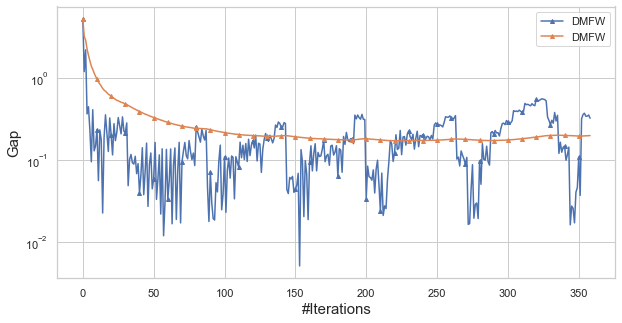

In [31]:
plt.figure(figsize=(10,5))
plt.plot(obj_val_ofw[:,0][:-1],obj_val_ofw[:,2][:-1], label='DMFW', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.plot(obj_val_ofw[:,0][:-1],average_loss(obj_val_ofw[:,2][:-1]), label='DMFW', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-4, 1e0))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Gap",fontsize=15)

Text(0, 0.5, 'Loss')

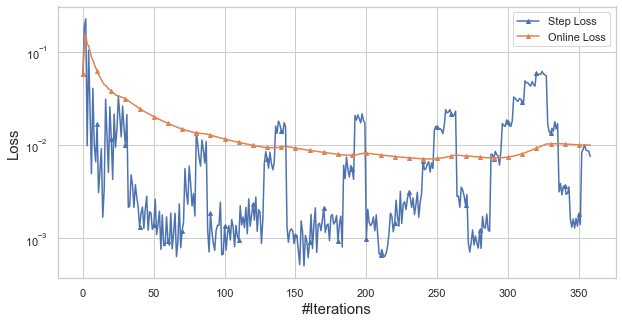

In [32]:
plt.figure(figsize=(10,5))
plt.plot(obj_val_ofw[:,0][:-1],obj_val_ofw[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.plot(obj_val_ofw[:,0][:-1],average_loss(obj_val_ofw[:,1][:-1]), label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-3, 1e2))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

In [33]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    #print(pred_array.shape)
    pred_shape = pred_array.shape
    #print(pred_shape)
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

In [34]:
def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_
        mini = scalers[zone_name].data_min_
        data_range = 1
        #true = ((true.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        #pred = ((pred.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        true = scalers[zone_name].inverse_transform(true.reshape(-1,1))
        pred = scalers[zone_name].inverse_transform(pred.reshape(-1,1))
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [35]:
def plotprediction(pandas): 
    plt.figure(figsize=(15,5))
    plt.title(f'{myfloor[indexroom]}')
    plt.plot(pandas["Truth"],label="Truth")
    plt.plot(pandas["Prediction"],label="Prediction",ls='-')
    plt.xticks(ticks=np.arange(pandas.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    plt.show()

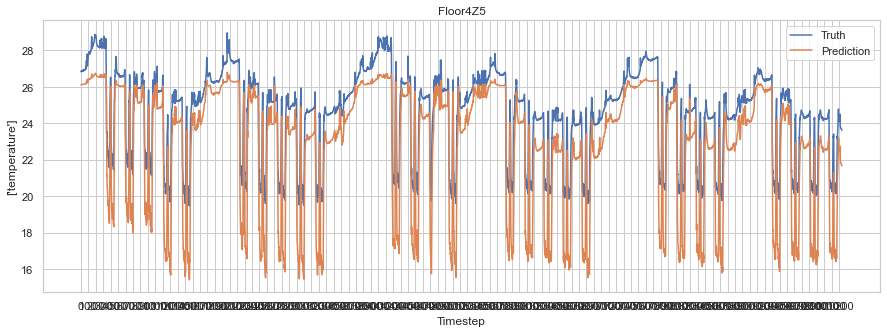

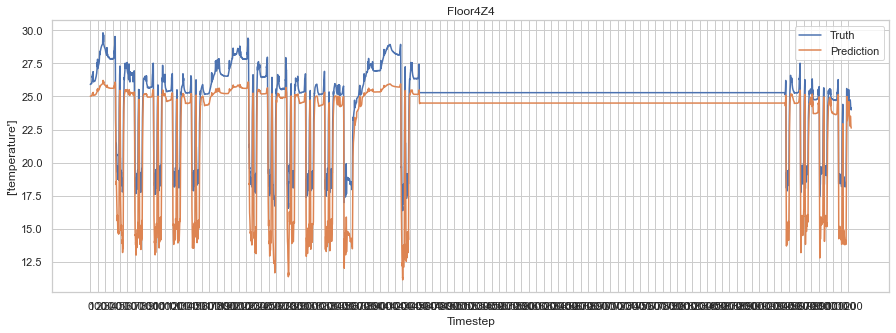

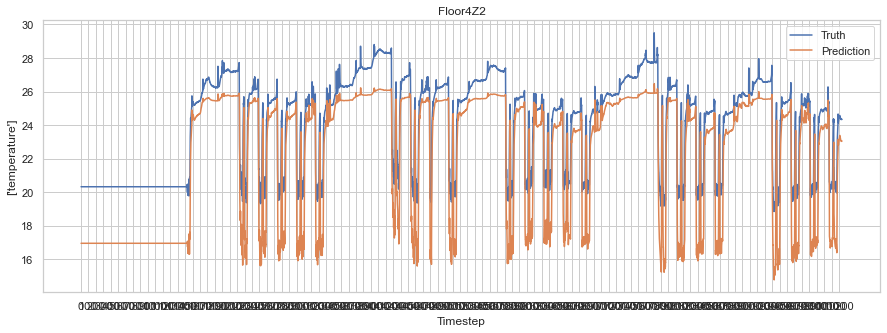

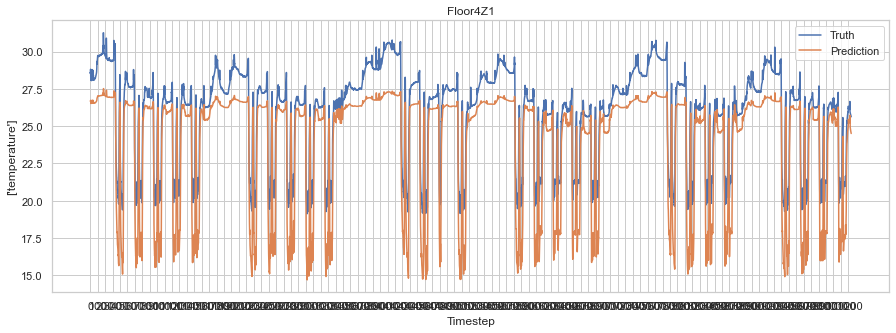

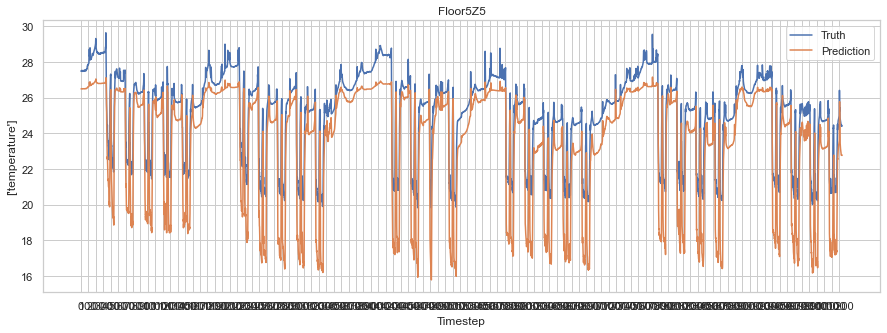

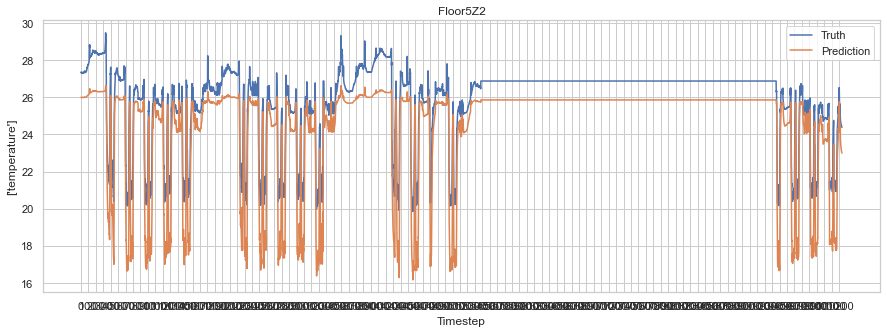

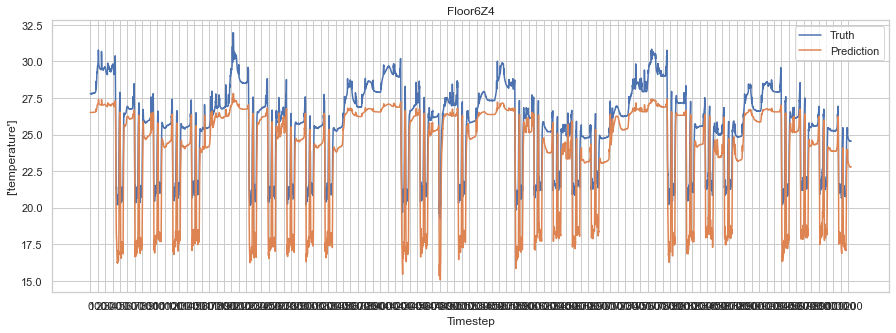

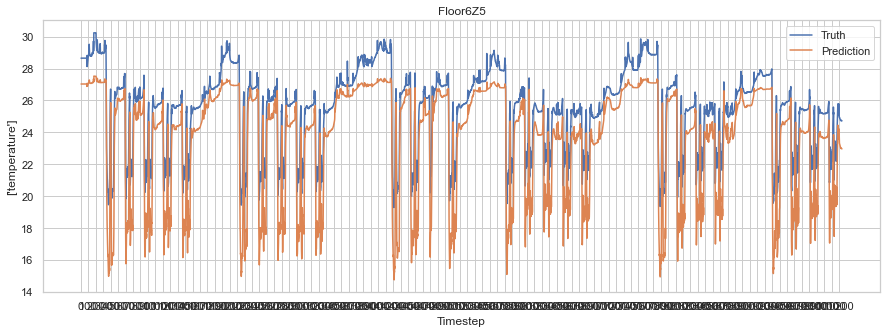

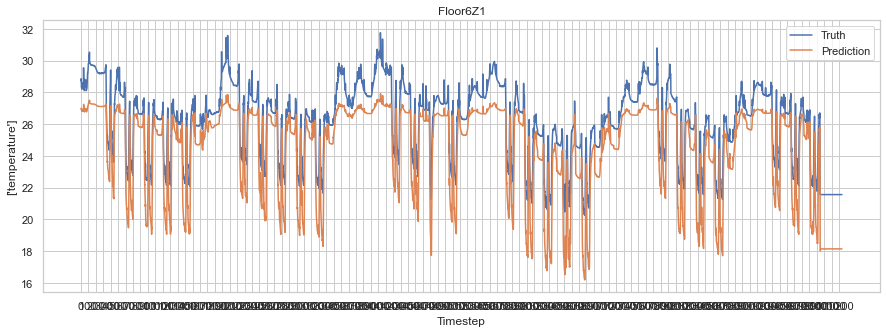

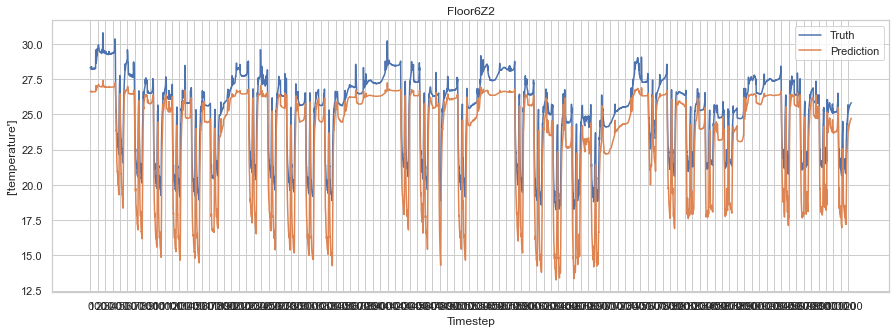

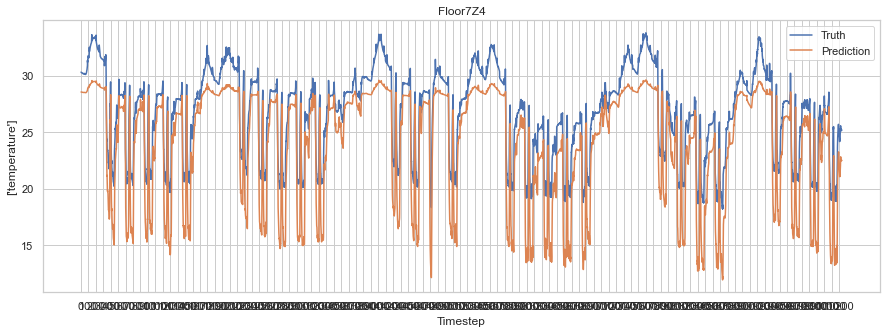

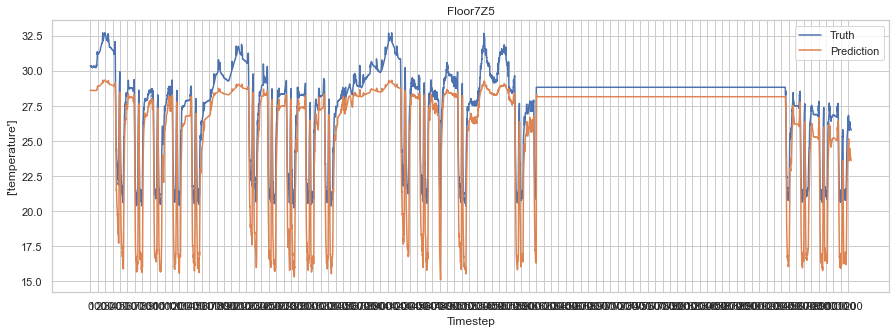

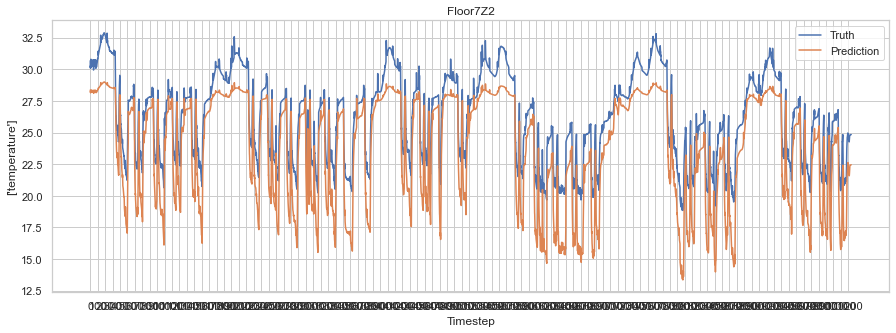

In [36]:
myfloor = zone_id#sorted(list(scaled_data.keys()))
may = [date for date in test_date if '2019-05' in date or "2019-04" in date]
for indexroom in range(len(trainloader)):
    mymodel = trainer.model_ofw
    resultpd = PredictionMultipleDate(mymodel,test_date,may[0], may[-1],testloader[indexroom], lookahead, scalers,
                                     myfloor[indexroom])
    plotprediction(resultpd)
    pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-{myfloor[indexroom]}.csv')